<h1><center> DC GAN <br />

<h2>Preliminares: Google Colab</h2>

Para evitar limitaciones de hardware, ejecute este notebook en Google Colab con GPU. Para ello siga estos pasos:

- Suba este notebook a su cuenta de Google Drive.
- Abra el notebook. Se hará automáticamente en Google Colab.
- En el menú "Entorno de ejecución", seleccione "Cambiar tipo de entorno de ejecución" y en "Acelerador por hardware" seleccione GPU.

<h2>Preliminares: PyTorch</h2>

Por simplicidad, en esta tarea se utilizará PyTorch. Se entrega una estructura general del código a implementar, con el objetivo de no requerir conocimientos profundos del framework utilizado. Además, se entregan <i> unit tests </i> que permitirán guiar su trabajo a través de los módulos.

<h2> Deep Convolutional GAN (DCGAN) </h2>

En esta sección, usted deberá implementar una [DCGAN](https://arxiv.org/pdf/1511.06434v1.pdf), el primer modelo de GAN convolucional desarrollado en el 2015. Alguna de las características de la DCGAN son mencionadas a continuación:

*   Usa convoluciones sin capas de pooling
*   Usa BatchNormalization tanto en el Generador como en el Discriminador
*   No usa capas <i> Fully Connected </i>
*   Usa activaciones ReLU en el Generador, salvo en la última capa donde usa Tanh.
*   Usa activaciones LeakyReLU en el Discriminador, salvo en la última capa donde no usa activación

A continuación se importan los paquetes a utilizar y se define una función útil para visualizar las imágenes generadas por la GAN.

In [1]:
from IPython import display
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0); # Set for testing purposes, please do not change!

In [2]:
# If you have multiple devices and just want to use one,
# then uncomment the following two lines:
# i_device = 1
# device = 'cuda:{0}'.format(i_device)
# Otherwise, uncomment the following line:
device = 'cuda'

In [3]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), save=False, name=None, epoch=None):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)

    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    if save:
        plt.savefig('{}_epoch_{}.png'.format(name, epoch))
    plt.show()

<h3> Bloque del Generador </h3>

Para comenzar, deberá implementar los bloques que componen el Generador.
Debido a que la función de activación varía según la capa, se deberá considerar esto al momento de la creación del bloque.

La estructura de cada bloque deberá ser la siguiente:
*   Una capa deconvolucional, utilizando los parámetros dados
*   Una capa de batchnorm, salvo en la última capa
*   Una activación ReLU después de cada batchnorm
*   Una activacion Tanh, sólo para la última capa

In [4]:
def make_gen_block(input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
    if not final_layer:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(output_channels),nn.ReLU()
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride),
            nn.Tanh()
        )

In [5]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

<h2> Generador</h2>

Ahora construya un Generador formado por 4 bloques, con las siguientes especificaciones:

    1.-block: z_dim          -> hidden_dim * 4 , kernel_size=3, stride=2
    2.-block: hidden_dim * 4 -> hidden_dim * 2 , kernel_size=4, stride=1
    3.-block: hidden_dim * 2 -> hidden_dim     , kernel_size=3, stride=2
    4.-block: hidden_dim     -> im_chan        , kernel_size=4, stride=2


In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            make_gen_block(self.z_dim,hidden_dim*4,kernel_size=3,stride=2),
            make_gen_block(hidden_dim*4,hidden_dim*2,kernel_size=4,stride=1),
            make_gen_block(hidden_dim*2,hidden_dim,kernel_size=3,stride=2),
            make_gen_block(hidden_dim,im_chan,kernel_size=4,stride=2,final_layer=True)
        )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

<h2> Tests Generador </h2>

In [7]:
gen = Generator()
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

In [8]:
# UNIT TESTS
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Well done !")

Well done !


<h3> Bloque del discriminador</h3>

Procederemos a implementar un bloque para el discriminador.
La estructura de cada bloque deberá ser la siguiente:

*    Una capa convolucional, utilizando los parámetros dados
*    Una capa de batchnorm, excepto por la última capa
*    Una activacion LeakyReLU de pendiente 0.2, sólo después de las capas de batchnorm

In [9]:
def make_disc_block(input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride),
                nn.BatchNorm2d(output_channels),nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride)

            )

<h2> Discriminador </h2>

Ahora construya un Discriminador formado por 3 bloques, con las siguientes especificaciones:

    1.-block: im_chan        -> hidden_dim     , kernel_size=4, stride=2
    2.-block: hidden_dim     -> hidden_dim * 2 , kernel_size=4, stride=2
    3.-block: hidden_dim * 2 -> 1              , kernel_size=4, stride=2

In [10]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            make_disc_block(im_chan,hidden_dim,kernel_size=4,stride=2),
            make_disc_block(hidden_dim,hidden_dim*2),
            make_disc_block(hidden_dim*2,1,final_layer=True)
        )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

<h2> Test Discriminador </h2>

In [11]:
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

In [12]:
# UNIT TESTS
# Test the hidden block
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block
assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Test the whole thing:

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.25
assert disc_output.std() < 0.5
print("Well done !")

Well done !


A continuación se definen los parámetros de entrenamiento a utlizar, y una funcion de utilidad para la inicialización de los pesos.

In [13]:
# Setting the training parameters
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 149325170.40it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 101114936.41it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39510574.20it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18353110.57it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [14]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

<h3> Funciones de Loss</h3>

Implemente los métodos `get_gen_loss` y `get_disc_loss` que calculen las funciones de <i> loss </i> del modelo original de GAN, con la solución al problema de <i> vanishing gradients </i>

In [15]:
x_entropy = nn.BCEWithLogitsLoss()

def get_gen_loss(disc_fake_pred):
    ### YOUR CODE HERE ###
    label = torch.ones(disc_fake_pred.size()[0], 1).to(device)
    gen_loss =  x_entropy(disc_fake_pred.squeeze(), label.squeeze())
    return gen_loss

def get_disc_loss(disc_fake_pred, disc_real_pred):
    ### YOUR CODE HERE ###
    real_label = torch.ones(disc_real_pred.size()[0], 1).to(device)
    fake_label = torch.zeros(disc_fake_pred.size()[0], 1).to(device)
    disc_loss = x_entropy(disc_fake_pred.squeeze(),fake_label.squeeze())+ x_entropy(disc_real_pred.squeeze(),real_label.squeeze())
    return disc_loss

<h2> Entrenamiento DCGAN </h2>

A continuación se proporciona el código para el entrenamiento de la DCGAN, utilizando los métodos anteriormente implementados.

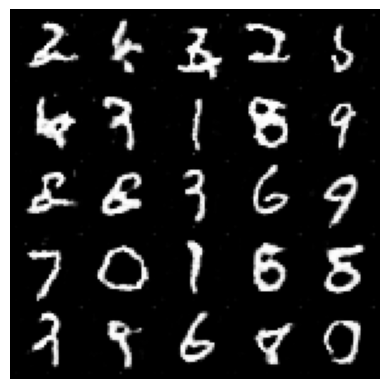

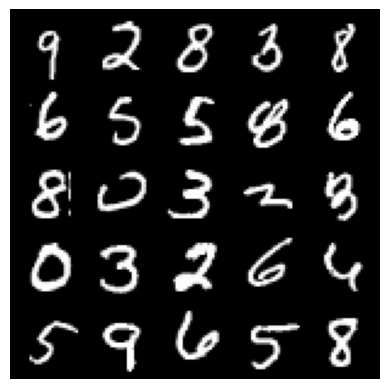

In [16]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        # Update discriminator
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_real_pred = disc(real)
        disc_loss = get_disc_loss(disc_fake_pred, disc_real_pred)

        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        # Update generator
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = get_gen_loss(disc_fake_pred)
        gen_loss.backward()
        gen_opt.step()
        mean_generator_loss += gen_loss.item() / display_step

        # Visualization code
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            display.clear_output(wait=True)
            show_tensor_images(fake, save=True, epoch=epoch, name='vanilla_dc_gan')
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


In [17]:
# Here you can either save or load a trained model
name = 'dcgan'
torch.save(gen.state_dict(), name)
# gen.load_state_dict(torch.load('dcgan'))